In [1]:
import os
from os import path

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load datasets...
train_dir = 'C:/Users/msrod/Desktop/Dataset/train'
valid_dir = 'C:/Users/msrod/Desktop/Dataset/validation'
test_dir = 'C:/Users/msrod/Desktop/Dataset/test'

In [3]:
# counting total file count in the entire training set.
totalFiles = 0

for root, dirs, files in os.walk(train_dir):
        for Files in files:
            totalFiles += 1

        
print('total files:', totalFiles)

total files: 3115


In [4]:
# although not really necessary count the number of files in each subfolder - numbers seem to be roughly even (around)
def count_files(path):
    for root, dirs, files in os.walk(path):
        print("{} files in {}".format(len(files), root))

count_files(train_dir)

0 files in C:/Users/msrod/Desktop/Dataset/train
68 files in C:/Users/msrod/Desktop/Dataset/train\apple
75 files in C:/Users/msrod/Desktop/Dataset/train\banana
88 files in C:/Users/msrod/Desktop/Dataset/train\beetroot
90 files in C:/Users/msrod/Desktop/Dataset/train\bell pepper
92 files in C:/Users/msrod/Desktop/Dataset/train\cabbage
89 files in C:/Users/msrod/Desktop/Dataset/train\capsicum
82 files in C:/Users/msrod/Desktop/Dataset/train\carrot
79 files in C:/Users/msrod/Desktop/Dataset/train\cauliflower
87 files in C:/Users/msrod/Desktop/Dataset/train\chilli pepper
87 files in C:/Users/msrod/Desktop/Dataset/train\corn
94 files in C:/Users/msrod/Desktop/Dataset/train\cucumber
84 files in C:/Users/msrod/Desktop/Dataset/train\eggplant
92 files in C:/Users/msrod/Desktop/Dataset/train\garlic
68 files in C:/Users/msrod/Desktop/Dataset/train\ginger
100 files in C:/Users/msrod/Desktop/Dataset/train\grapes
88 files in C:/Users/msrod/Desktop/Dataset/train\jalepeno
88 files in C:/Users/msrod/Des

In [5]:
# getting a list of all the class names
def get_subdirname(path):
    return [name for name in os.listdir(path) # listdir() returns a list containing the names of the entries in the directory given by path. The list is in arbitrary order.
            if os.path.isdir(os.path.join(path, name))]

class_names = get_subdirname(train_dir)
class_names

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [6]:
def transform_ds(path):
    # label_mode='categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    tf_ds = tf.keras.utils.image_dataset_from_directory(path, labels='inferred', label_mode='categorical', 
                                                        image_size=(128, 128), batch_size=32, seed=42)
    
    print("tf.data.dataset from image files in directory created.")
    
    return tf_ds

In [7]:
# alright, alright, alright we have our tf-dataset. => it yields a tuple (images, labels)
train_ds = transform_ds(train_dir)
valid_ds = transform_ds(valid_dir)
test_ds = transform_ds(test_dir)

Found 3115 files belonging to 36 classes.
tf.data.dataset from image files in directory created.
Found 351 files belonging to 36 classes.
tf.data.dataset from image files in directory created.
Found 359 files belonging to 36 classes.
tf.data.dataset from image files in directory created.


In [8]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [9]:
train_ds.take(1)


<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 36), dtype=tf.float32, name=None))>

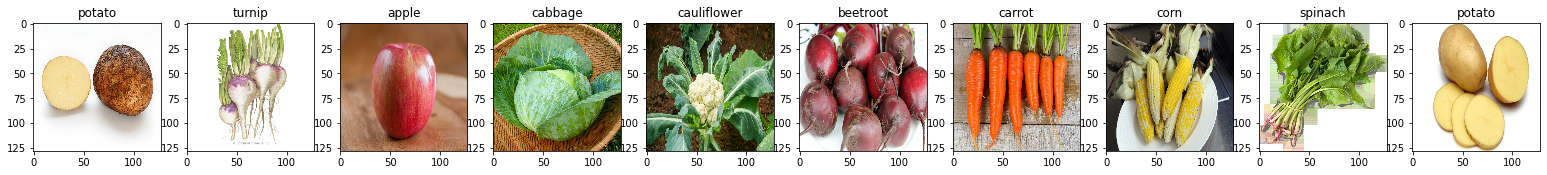

In [10]:
# display some fruits and vegetables
plt.figure(figsize=(27, 20))

for image, label in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(image[i].numpy().astype('int'))
        plt.title(train_ds.class_names[tf.argmax(label[i])])

In [11]:
# augment images a little bit
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

# rescale images
rescaling = keras.Sequential([
    layers.Rescaling(1./255) # standardizes pixel values to the [0, 1] range.
])

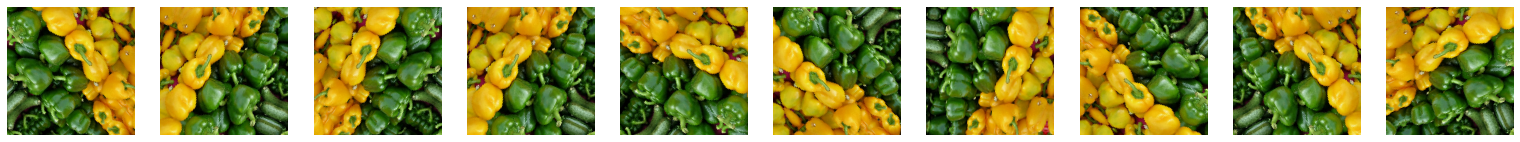

In [12]:
plt.figure(figsize=(27, 20))
for image, label in train_ds.take(1):
    for i in range(10):
        augmented_image = data_augmentation(image)
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) # batch = 32
    print(labels_batch.shape)
    
    break

(32, 128, 128, 3)
(32, 36)


In [14]:
# always buffer and prefetch(!)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
res50 = ResNet50(include_top=False, weights = 'imagenet', input_shape=(128, 128, 3))
res50.trainable = False

In [16]:
model = Sequential()
model.add(res50)
model.add(layers.Flatten())
model.add(layers.Activation('relu'))
model.add(layers.Dense(36))
model.add(layers.Activation('softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 activation (Activation)     (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 36)                1179684   
                                                                 
 activation_1 (Activation)   (None, 36)                0         
                                                                 
Total params: 24,767,396
Trainable params: 1,179,684
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(train_ds, batch_size=32, epochs=2, validation_data=valid_ds, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/2
98/98 [==============================] - 443s 4s/step - loss: 7.7324 - accuracy: 0.4777 - val_loss: 1.7831 - val_accuracy: 0.8632
Epoch 2/2
98/98 [==============================] - 349s 4s/step - loss: 2.1579 - accuracy: 0.8350 - val_loss: 2.0138 - val_accuracy: 0.9060


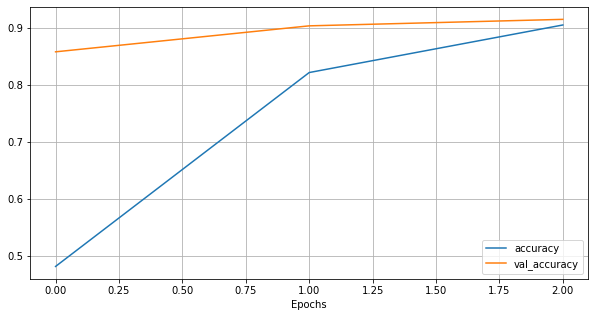

Text(0.5, 0, 'Epochs')

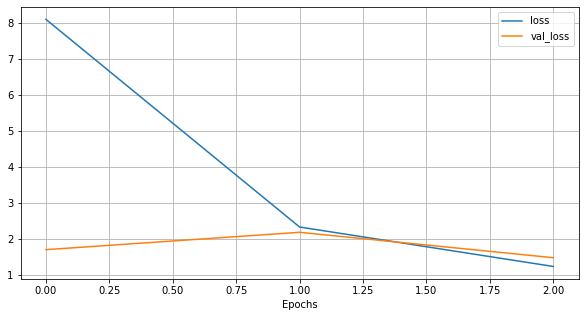

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.grid(True)
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.xlabel('Epochs')

In [21]:
model.evaluate(train_ds, verbose=1)


98/98 [==============================] - 451s 5s/step - loss: 0.7527 - accuracy: 0.9368


[0.7526755332946777, 0.9367576241493225]

In [19]:
model.metrics_names 


['loss', 'accuracy']

1/1 [==============================] - 7s 7s/step


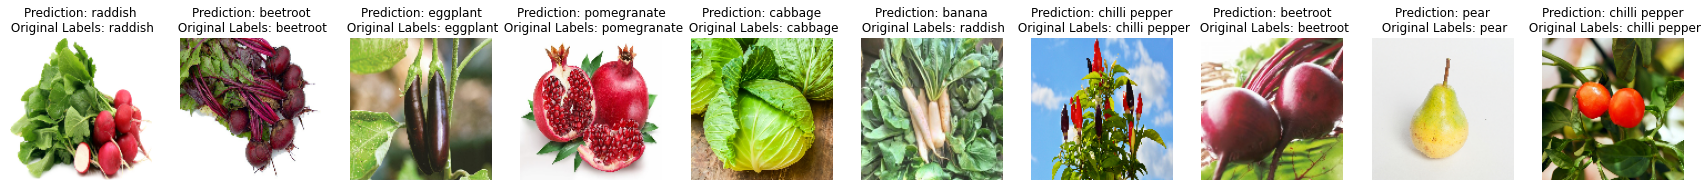

In [20]:
test_labels = test_ds.class_names

plt.figure(figsize=(30,25))

for image, label in train_ds.take(1):
    model_prediction = model.predict(image)
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(image[i].numpy().astype('int'))
        plt.title(f"Prediction: {test_labels[tf.argmax(tf.round(model_prediction[i]))]}\n Original Labels: {test_labels[tf.argmax(label[i])]}")
        plt.grid(True)
        plt.axis('off')
        
    plt.show()

In [30]:
model.save('C:\\Users\\msrod\\Desktop\\model.h5')

In [49]:
import cv2
image = cv2.imread('C:/Users/msrod/Desktop/Dataset/test/pear/Image_1.jpg')
image = cv2.resize(image, (128,128))
pred = model.predict(np.expand_dims(image, axis=0))[0]

print(image.shape)

1/1 [==============================] - 0s 164ms/step
(128, 128, 3)


In [50]:
output_class = class_names[np.argmax(pred)]
print("Predict", output_class)

Predict pear
